In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.patheffects as path_effects
import seaborn as sns
from unicodedata import normalize
import re
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob



In [93]:
# # pip install sqlalchemy pg8000 
# # !pip install sqlalchemy_utils
# !pip install wordcloud textblob

In [94]:
from sqlalchemy import create_engine, exists, MetaData, Table, BigInteger, Boolean,CHAR, select,  Column, DateTime, Integer, String, insert, update
from sqlalchemy.orm import sessionmaker, Session
from sqlalchemy_utils import database_exists, create_database
# from github_setup import postgresql as settings
from sqlalchemy.ext.declarative import declarative_base
from twitter_config import pins


url = f"postgresql+pg8000://{pins['user']}:{pins['password']}@{pins['host']}:{pins['port']}/{pins['db_name']}"

engine = create_engine(url)

Session = sessionmaker(bind=engine)

Base = declarative_base()

In [95]:
class Twitter(Base):
    """twitter table"""

    __tablename__ = "twitter"
    
    tweet_id = Column(String, primary_key=True)
    asa_id   = Column(String)
    user_id  = Column(String) 
    text     = Column(String)
    posted_at= Column(DateTime)   
    hashtags = Column(String)
    

class Interactions(Base):
    """Interactions table"""

    __tablename__ = "interactions"

    tweet_id = Column(String, primary_key=True)
    likes = Column(Integer)
    retweets = Column(Integer)
    protected = Column(Boolean)


Base.metadata.create_all(engine)


In [96]:
db = Session()

In [97]:
id_twitter = db.query(Twitter).all()

id_inter = db.query(Interactions).all()


### Transform class  tested !!!!!!!

In [98]:
class Transform():
    def __init__(self):
        self.data = None
    
    def get_twitter_df(self, ids, twitter_col:list):
        data = []
        for i in range(len(ids)):
            a,b,c,d,e,f = ids[i].tweet_id, ids[i].asa_id, ids[i].user_id, ids[i].text, ids[i].posted_at, ids[i].hashtags
            arr = np.array([a,b,c,d,e,f])
            data.append(arr)
        array = np.array(data)
        df = pd.DataFrame(array, columns = twitter_col)
        return df
    
    def get_inter_df(self, ids, inter_col:list):
        data = []
        for i in range(len(ids)):
            a,b,c,d = ids[i].tweet_id, ids[i].likes, ids[i].retweets, ids[i].protected
            arr = np.array([a,b,c,d])
            data.append(arr)
        array = np.array(data)
        df = pd.DataFrame(array, columns = inter_col)
        return df
    
    def merge_dfs(self, df1, df2):
        df = pd.merge(df1, df2, how = 'inner', on = 'tweet_id')
        
        return df
    
    def clean_tweet(self, tweet):
        tweet = normalize('NFKD', tweet).encode('ascii', 'ignore').decode('utf-8')
        tweet = str(tweet)
        tweet = re.sub('(RT\s(@\w+))', '', tweet)
        tweet = re.sub('@\\w+', '', tweet)

        tweet = re.sub('((http|https):(\S+))', '', tweet)
        tweet = re.sub('[!#?:*%$]', ' ', tweet)
        tweet = re.sub('[^\s\w+]', '', tweet)
        tweet = re.sub('[\n]', '', tweet)
        tweet = tweet.lower().strip()
        return tweet
    
    def clean_id(self,df, column):
        new = []
        for s in df[column]:
            s = s.lower()
            n = s.replace('{', '')
            n = n.replace('}', '')
            new.append(n)
        df[column] = new
        return df
    
    def fix_type(self, df):
#         data = self.data
        for i in df.columns:
            if i in ['likes', 'retweets']:
                df[i] = df[i].astype('int64')
            if i in ['protected']:
                df[i] = df[i].astype(bool)
            
        return df
    
    def choose_asa(self, df):
#         data = self.data
        asa = input("Hey Nigga! \nWhat ASA would you like to analyze? ").lower()
        data_asa = df[df['asa_id'].str.contains(asa, case = False)]
        data_asa.reset_index(inplace = True)
        return data_asa
    
    def alll(self):
        col_t = ['tweet_id', 'asa_id', 'user_id', 'text', 'posted_at', 'hashtags']
        col_i = ['tweet_id', 'likes', 'retweets', 'protected']
        df_twitter = self.get_twitter_df(id_twitter, col_t)
        df_inter = self.get_inter_df(id_inter, col_i)
        df = self.merge_dfs(df_twitter, df_inter)
        df['clean_tweet'] = df.text.apply(self.clean_tweet)
        df = self.clean_id(df, 'asa_id')
        df = self.fix_type(df)
        df_final = self.choose_asa(df)
        return df_final
        


In [99]:
df_c = Transform().alll()

Hey Nigga! 
What ASA would you like to analyze? algomint


In [100]:
df_c['likes'].max()

43

## Likes class tested and works with transform

In [101]:
class Likes():
    
    def __init__(self, data, entity_col:str, datetime_col):
        
        self.data = data
        self.entity_col = entity_col
        self.datetime_col = data[datetime_col]
    
    def day_of_week(self):
        data = self.data
        date = self.datetime_col
        day = date.dt.weekday
        data['day_of_week'] = day.to_list()
        encode_dict = {1: 'Sunday', 2:'Monday', 3:'Tuesday',
                        4: 'Wednesday', 5: 'Thursday',
                        6: 'Friday', 7: 'Saturday'}
        data['day_of_week'] = data['day_of_week'].replace(encode_dict)

        return data
    def hour_of_day(self):
        data = self.data
        date = self.datetime_col
        time = date.dt.hour
        data['hour_of_day'] = time.to_list()
        return data
    def plot(self, weekday = False, timeofday = False):
        data = self.data
        entity = self.entity_col
#         if weekday & timeofday:
#             df1 = self.DayOfWeek()
#             h = df1.groupby('day_of_week')['retweets'].sum()
#             df2 = self.TimeOfDay()
#             c = df2.groupby('hour_of_day')['likes'].sum()
#             plt.bar(h.index, h)
#             plt.plot(c)
#             plt.show()
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(12,4))
        
        if weekday:
            df = self.day_of_week()
            h = df.groupby('day_of_week')[entity].sum()
            plt.title(f'{entity} per day of the week')
            plt.xlabel('day of the week')
            plt.ylabel(f'{entity}')
            plt.bar(h.index, h, color=['green'])
            plt.show()
        elif timeofday:
            df = self.hour_of_day()
            c = df.groupby('hour_of_day')[entity].sum()
            plt.title(f'Trend of {entity} per hour of day')
            plt.xlabel('Hour of the day')
            plt.ylabel(f'{entity}')
            plt.plot(c, 'g-o',path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
            plt.show()

        else:
            
            plt.title(f"Trend of {entity}")
            plt.ylabel(f'{entity}')
            plt.xlabel('index')
            plt.plot(data[entity], 'g-o', path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
#         return p
    


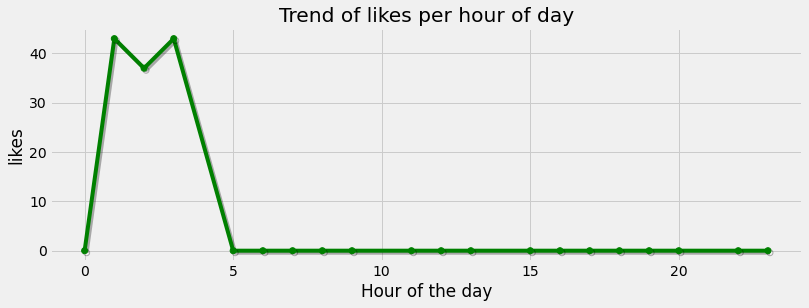

In [102]:
check = Likes(df_c, 'likes', 'posted_at')
check.plot(timeofday=True)


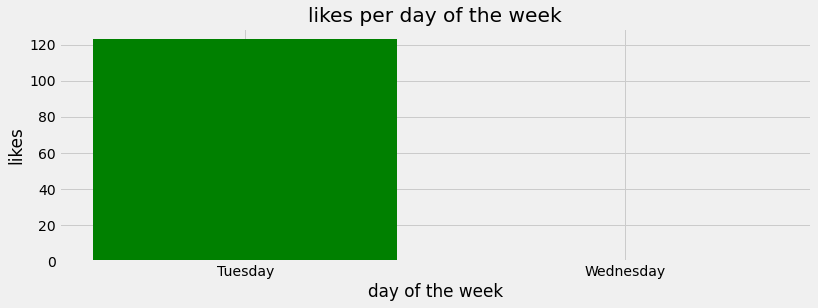

In [103]:
check.plot(weekday = True)

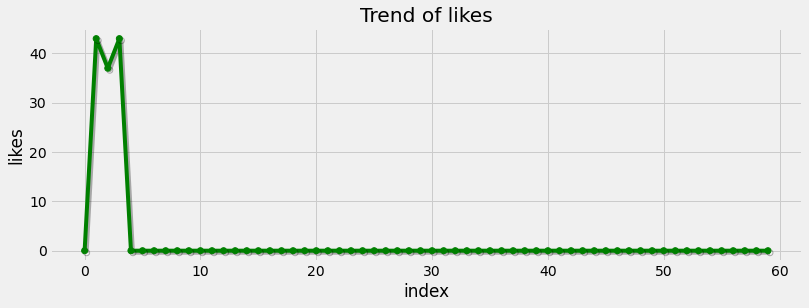

In [104]:
check.plot()

In [105]:
class Retweets(Likes):
    pass
    

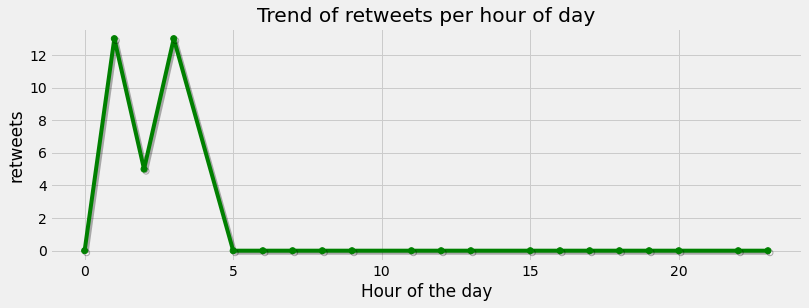

In [106]:
ret = Retweets(df_c, 'retweets', 'posted_at')
ret.plot(timeofday=True)


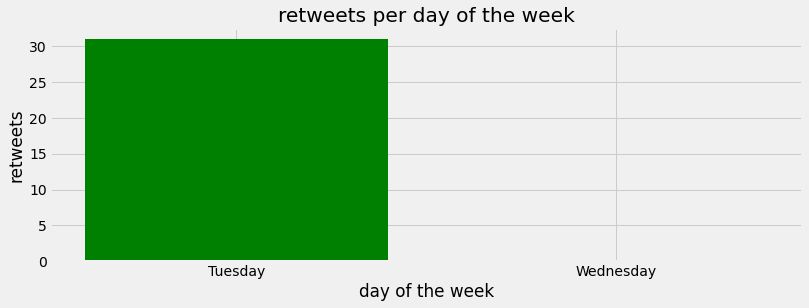

In [107]:
ret.plot(weekday = True)

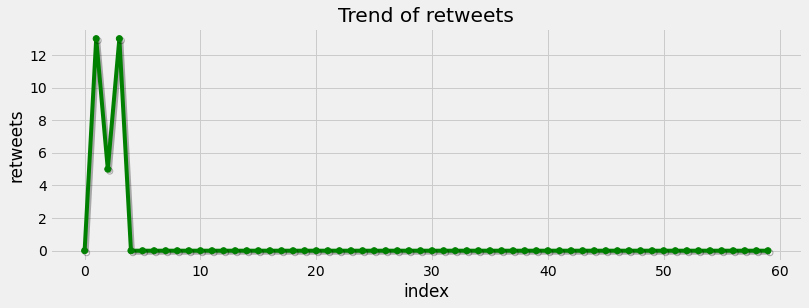

In [108]:
ret.plot()

In [109]:
class Text():
    
    def __init__(self, df, column:str):
        self.df = df
        self.column = column
        self.text = df[column]
        
    def wordcloud(self):
        text = self.text
        
        comment_words = ''
        stopwords = set(STOPWORDS)
 
        # iterate through the csv file
        for val in text:
     
            # typecaste each val to string
            val = str(val)
 
            # split the value
            tokens = val.split()
     
            # Converts each token into lowercase
            for i in range(len(tokens)):
                tokens[i] = tokens[i].lower()
     
            comment_words += " ".join(tokens)+" "
 
        wordcloud = WordCloud(width = 900, height = 300,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
        # plot the WordCloud image 
        plt.style.use('fivethirtyeight')
        plt.figure(figsize = (15, 10), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
 
        return plt.show()
        
    def sentiment(self):
        df = self.df
        column = self.df
        text = self.text
        senti = []
        score = [TextBlob(t).sentiment.polarity for t in text ]
        for s in score:
            if s > 0:
                senti.append(1)
            elif s == 0:
                senti.append(0)
            else:
                senti.append(-1)
        df['sentiment_score'] = senti
        return df
    def plot_sentiment(self):
        df = self.sentiment()
        
        code = {1: 'positive', -1: 'negative', 0:'neutral'}
        df['sentiment_score'].replace(code, inplace = True)
        s = df['sentiment_score'].value_counts()
        
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(12,4))
        plt.title('Sentiment Analysis')
        plt.xlabel('Category')
        plt.ylabel('Score')
        plt.bar(s.index, s, color=['green'])
        plt.show()
        

In [110]:
df_c.columns

Index(['index', 'tweet_id', 'asa_id', 'user_id', 'text', 'posted_at',
       'hashtags', 'likes', 'retweets', 'protected', 'clean_tweet',
       'hour_of_day', 'day_of_week'],
      dtype='object')

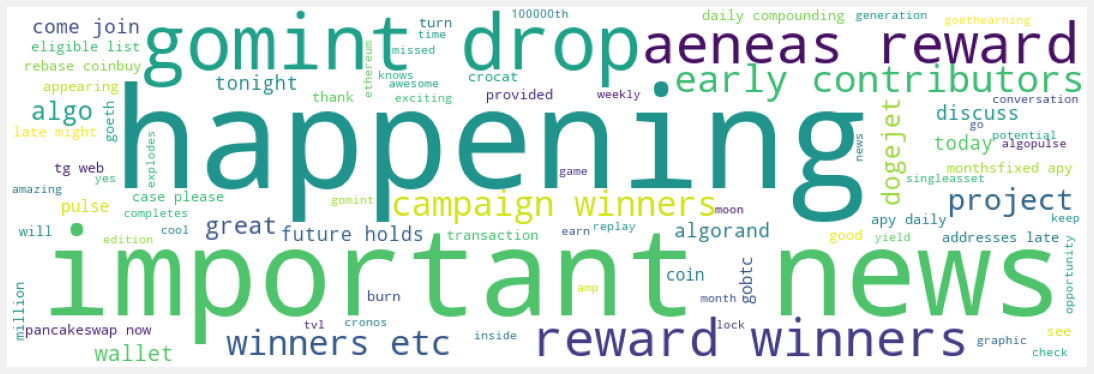

In [111]:
t = Text(df_c, 'clean_tweet')
t.wordcloud()

In [112]:
t.sentiment().head()

,index,tweet_id,asa_id,user_id,text,posted_at,hashtags,likes,retweets,protected,clean_tweet,hour_of_day,day_of_week,sentiment_score
0,131,1514395601902858245,algomint_io,14723940,@Algomint_io @ethereum The Ethereum blockchain...,2022-04-14 00:10:22,{},0,0,True,the ethereum blockchain is such a joke time fo...,0,Tuesday,0
1,222,1514417085153103873,algomint_io,1366618666368864258,RT @Algomint_io: Lock &amp; Earn with @FolksFi...,2022-04-14 01:35:44,{},43,13,True,lock amp earn with your singleasset yield ge...,1,Tuesday,0
2,345,1514433563483009024,algomint_io,18661453,RT @pact_fi: He knows. 🧠\n\n@Algomint_io @Drake,2022-04-14 02:41:13,{},37,5,True,he knows,2,Tuesday,0
3,462,1514443206456492039,algomint_io,345915295,RT @Algomint_io: Lock &amp; Earn with @FolksFi...,2022-04-14 03:19:32,{},43,13,True,lock amp earn with your singleasset yield ge...,3,Tuesday,0
4,567,1514472757379096580,algomint_io,1344063329581604864,RT @pact_fi: He knows. 🧠\n\n@Algomint_io @Drake,2022-04-14 05:16:57,{},0,0,True,he knows,5,Tuesday,0


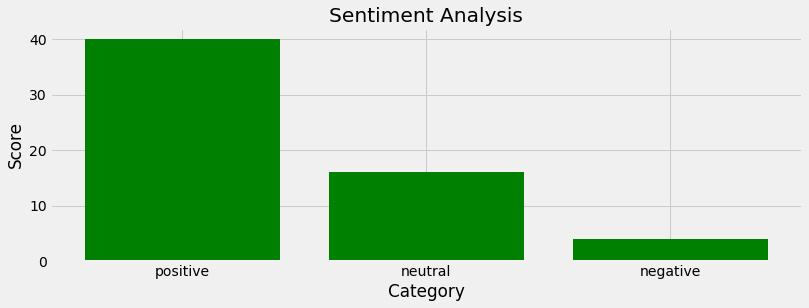

In [113]:
t.plot_sentiment()